---
### Invert with regularization.
Please check the original paper:\
[Felipe A. Bulat, Tim Heaton-Burgess, Aron J. Cohen, and Weitao Yang, J. Chem. Phys. 127, 174101 (2007)](https://aip.scitation.org/doi/full/10.1063/1.2800021?casa_token=-ZgE4QLD_g0AAAAA%3AEKtFcuAPeo8_BGf_3CHsaCfPBletRKQgCgwE87XnpcJzZ1x_TPdeqDTltYzC9Uj9rqcukhbtOgAlhA)\
[Tim Heaton-Burgess, Felipe A. Bulat, and Weitao Yang, PRL 98, 256401 (2007)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.256401)

In [4]:
from pyscf import gto
import matplotlib.pyplot as plt
import numpy as np
import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

In [5]:
# Define Molecule
mol = gto.M(atom = """
                  Ne
                  """,
basis = 'cc-pvdz')

# Perform Calculation
mf = mol.KS()
mf.xc = 'scan'
mf.kernel()

# Extract data for n2v. 
da, db = mf.make_rdm1()/2, mf.make_rdm1()/2
ca, cb = mf.mo_coeff[:,:mol.nelec[0]], mf.mo_coeff[:, :mol.nelec[1]]
ea, eb = mf.mo_energy, mf.mo_energy

# Initialize inverter object. 
inv = n2v.Inverter( engine='pyscf' )

inv.set_system( mol, 'cc-pvdz', pbs='cc-pvqz' )
inv.Dt = [da, db]
inv.ct = [ca, cb]
inv.et = [ea, eb]


converged SCF energy = -128.882414403919
converged SCF energy = -128.156135758435  <S^2> = -2.6645353e-15  2S+1 = 1


#### Result without regularization

In [7]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.invert("WuYang", opt_max_iter=100, opt_method="trust-exact", gtol=1e-4,
           guide_components="fermi_amaldi")

Optimization Successful within 3 iterations! |grad|=5.03e-05


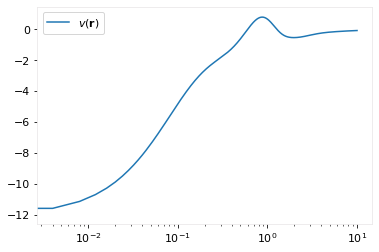

In [16]:
# Build Grid
inv.eng.grid.build_rectangular((5001,1,1))
x = inv.eng.grid.x

#Compute components
vH = inv.eng.grid.hartree(density=da+db, grid='rectangular')
vFA = (1 - 1/(inv.nalpha + inv.nbeta)) * vH
vrest = inv.eng.grid.to_grid(inv.v_pbs, grid='rectangular')

# Generate inverted vxc
vxc = vFA + vrest - vH

fig, ax = plt.subplots()
ax.plot(x, vxc, label="$v(\mathbf{r})$")
ax.legend()
ax.set_xscale('log')
fig.show()

The regularization term
$$\lambda\|{\nabla v_{pbs}}\|^2=\lambda \textbf{b}^T\textbf{T}\textbf{b},$$
where $\textbf{b}$ is the coefficient of $v_{pbs}$ on potential basis set (pbs) and $\textbf{T}$ is the kinetic energy intergral maxtrix in pbs.

This term is subtracted from the Lagrangian.

There are strategies to search for $\lambda$. Accoding to the two paper I cited above,
$$
P(\lambda) = \lambda \frac{\|v_{pbs}(\lambda)\|^2}{L^{\lambda=0}-L^{\lambda}},
$$
is used. where $L$ is the Lagrangian.

In [18]:
lambda_list, P, Ts = inv.find_regularization_constant_wy(opt_max_iter=100, 
                                                      opt_method="trust-exact",
                                                      lambda_list=10 ** np.linspace(-1,-7,21))
print("lambda:\n", lambda_list)
print("P:\n", P)

lambda:
 [1.00000000e-01 5.01187234e-02 2.51188643e-02 1.25892541e-02
 6.30957344e-03 3.16227766e-03 1.58489319e-03 7.94328235e-04
 3.98107171e-04 1.99526231e-04 1.00000000e-04 5.01187234e-05
 2.51188643e-05 1.25892541e-05 6.30957344e-06 3.16227766e-06
 1.58489319e-06 7.94328235e-07 3.98107171e-07 1.99526231e-07
 1.00000000e-07]
P:
 [1.08203104e-01 1.93622666e-01 3.07566987e-01 3.92851072e-01
 3.72869524e-01 2.97686844e-01 2.43128857e-01 2.51821204e-01
 3.45744088e-01 5.61302051e-01 9.71588318e-01 4.25688641e+00
 7.20212093e+00 1.22488838e+01 1.29607330e+02            inf
            inf            inf            inf            inf
            inf]


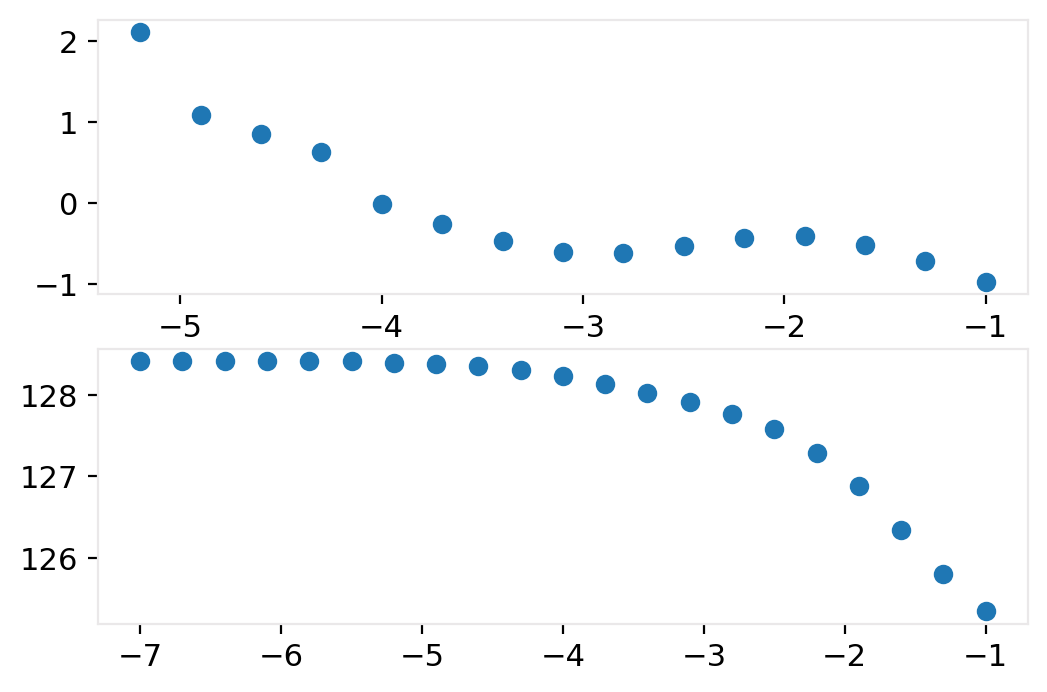

In [19]:
fig, axes = plt.subplots(2,1,dpi=200)
axes[0].scatter(np.log10(lambda_list), np.log10(P), label="P")
axes[1].scatter(np.log10(lambda_list), Ts, label="Ts")

Following the $\lambda$ suggested by P, detailed discussed in [J. Chem. Phys. 129, 194102 (2008)](https://doi.org/10.1063/1.2982799). We choose:

In [20]:
lambda_list[13]

1.2589254117941661e-05

In [23]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.v_pbs = np.zeros_like(inv.v_pbs)
inv.invert("WuYang", opt_method="trust-exact", 
           guide_components="fermi_amaldi", reg=lambda_list[13], gtol=1e-4)

Optimization Successful within 3 iterations! |grad|=6.39e-07


In [27]:
vrest_P = inv.eng.grid.to_grid(inv.v_pbs, grid='rectangular')
vxc_P = vFA + vrest_P - vH

Following the $\lambda$ suggested by Ts (the edge of the L curve in the bottom panel)

In [28]:
lambda_list[12]

2.5118864315095822e-05

In [30]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.v_pbs = np.zeros_like(inv.v_pbs)
inv.invert("WuYang", opt_method="trust-exact", 
           guide_components="fermi_amaldi", 
           reg=lambda_list[12], gtol=1e-4)

Optimization Successful within 3 iterations! |grad|=2.46e-07


In [31]:
vrest_Ts = inv.eng.grid.to_grid(inv.v_pbs, grid='rectangular')
vxc_Ts = vFA + vrest_Ts - vH

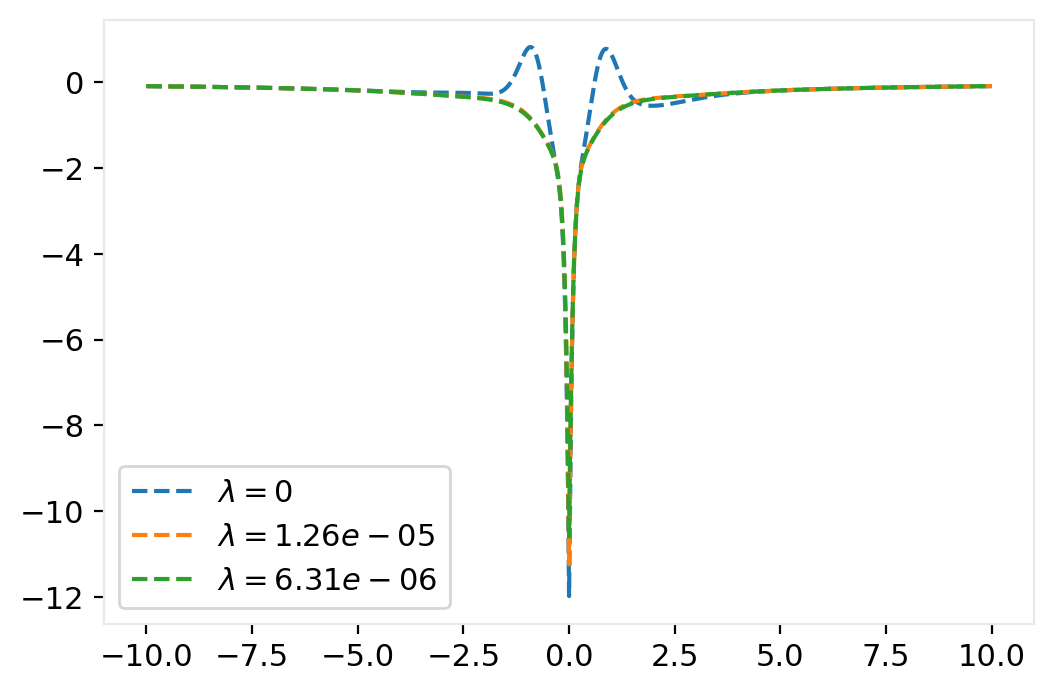

In [32]:
fig, ax = plt.subplots(dpi=200)
# ax.plot(xyz, vxc_exact, label="exact")
ax.plot(x, vxc, label="$\lambda=0$", ls='--')
ax.plot(x, vxc_P, label="$\lambda=%.2e$"%lambda_list[13], ls='--')
ax.plot(x, vxc_Ts, label="$\lambda=%.2e$"%lambda_list[14], ls='--')
ax.legend()